# Description

#### O Desafio

Você faz parte do time de cientistas de dados da empres All In One Place, que precisa determinar quem são os clientes elegíveis para participar do Insiders. Em posse dessa lista, o time de Marketing fará uma sequência de ações personalizadas e exclusivas ao grupo, de modo a aumentar o faturamento e a frequência de compra.
Como resultado para esse projeto, é esperado que você entregue um lista de pessoas elegíveis a participar do programa Insiders, junto com um relatório respondendo às seguintes perguntas:

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
2. Quantos clinetes farão parte do grupo?
3. Quais as principais características desses clientes?
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
5. Qual a expectativa de faturamento desse grupo para os próximos meses?
6. Quais as condições para uma pessoa ser elegível ao Insiders?
7. Quais as condições para uma pessoa ser removida do Insiders?
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

#### Os dados

- Invoice Number: Identificador único de cada transação.
- Stock Code Product: Código do item
- Description Product: nome do item
- Quantity: A quantidade de item comprado por transação.
- Invoice Date: O dia em que a transação ocorreu.
- Unit Price: Preço do produto por unidade.
- Customer ID: Identificador único do cliente
- Country: O nome do pais que o cliente reside.

# Solution Planning

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - Monetário
        - valor médio dos pedidos
        - LTV
        - valor total dos pedidos
    - Recencia
        - Quantas vezes o cliente comprou
    - Frequencia
        - Frequencia de compra
        
        
2. Quantos clinetes farão parte do grupo?
    - Total de clientes + percentual sobre a base.
    
    
3. Quais as principais características desses clientes?
    - Lista das principais caracteristicas de compra.


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Percentual de faturamento do grupo sobre o total de vendas.


5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Previsão de faturamento.

6. Quais as condições para uma pessoa ser elegível ao Insiders?
7. Quais as condições para uma pessoa ser removida do Insiders?
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A\B
    - Teste A\B gausiano
    - 


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?


#### Benchmark

- RFM
    - https://www.optimove.com/resources/learning-center/customer-segmentation-via-cluster-analysis
    - https://www.techtarget.com/searchdatamanagement/definition/RFM-analysis?
    - https://www.omniconvert.com/blog/rfm-score/ - segments
- K-Means
    - https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3
    - Elbow Method Visualizer
    
    
        from yekkiwbrick.cluster import KElbowVisualiser
        Elbow_M = KElbowVisualizer(KMeans(), k=10)
        Elbow_M.fit(PCA_ds)
        Elbow_M.show()

#### Ideias de entrega
- Começar aplicando RFM para gerar valor e trazer as principais caracteristicas dos clientes.
- Relatório de Insights
- Algoritmo K-means (usar RFM para entrada)
- Relatório Final

#### Ideias para outros algoritmos
- Ativação de recompra
    - Identificar o momento certo de mandar propagandas e promoções para o cliente 'lembrar' de comprar na loja.
- Previsão de classificação
    - Prever em qual classificação o cliente vai se encaixar. Com isso podemos direcionar o marketing para que ele possa subir no nosso rank de clientes.

# 0. Imports & Help Functions

## 0.1 Imports

In [410]:
import inflection
import re

import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

from matplotlib import pyplot  as plt
from sklearn    import metrics as mt

from sklearn.preprocessing   import LabelEncoder
from sklearn.cluster         import KMeans, DBSCAN
from sklearn.ensemble        import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing   import MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.decomposition   import PCA
from sklearn.manifold        import TSNE
from sklearn.metrics         import silhouette_score, silhouette_samples
from sklearn.mixture         import GaussianMixture
from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer
from IPython.display         import HTML
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.neighbors       import NearestNeighbors

## 0.2 Data Import

In [411]:
df_raw = pd.read_csv('dataset/ecommerce.csv', encoding='windows-1252')
df_raw = df_raw.drop(columns='Unnamed: 8')

##### 0.3 Help Functions

In [412]:
# Função para extração do número no stock_code
def extraction(x):
    match = re.search('\d+', x)
    if match:
        return match.group(0)
    else:
        return None
    
# Função para análise exploratória

def exploratori(df4):
    sns.set(rc={'figure.figsize':(15,5)})

    for coluna in df4.columns:
        plt.figure()

        if pd.api.types.is_numeric_dtype(df4[coluna]):
            # Feature name
            html_content = "<h1>" + coluna.upper() + "</h1>"
            display(HTML(html_content))        

            # Plots
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df4[coluna])
            plt.title(f"Boxplot da coluna '{coluna}'")

            plt.subplot(1, 2, 2)
            sns.histplot(data=df4[coluna], kde=True)
            plt.title(f"Histograma da coluna '{coluna}'")

            # Statistcs
            aux1 = pd.DataFrame(data={'feature':[coluna]}, index=['statistcs'])
            aux1['average'] = df4[coluna].mean()
            aux1['min'] = df4[coluna].min()
            aux1['median'] = df4[coluna].median()
            aux1['max'] = df4[coluna].max()
            aux1['std_deviation'] = df4[coluna].std()

            plt.show()
            display(HTML(aux1.to_html()))
            
def find_elbow(data, theta): # Função para encontrar o cotovelo da curva

    # make rotation matrix
    co = np.cos(theta)
    si = np.sin(theta)
    rotation_matrix = np.array(((co, -si), (si, co)))

    # rotate data vector
    rotated_vector = data.dot(rotation_matrix)

    # return index of elbow
    return np.where(rotated_vector == rotated_vector[:, 1].min())[0][0]

def get_data_radiant(data): # Função para encontar o theta
    return np.arctan2(data[:, 1].max() - data[:, 1].min(), 
                    data[:, 0].max() - data[:, 0].min())

# ------------------------------

# --- Detecção de OutLiers --- #

# Outliers inferiores
# Q_1 - 1,5 . A_q

# Outliers superiores
# Q_3 + 1,5 . A_q

# ------------------------------

def outliers_detect(data):
    # Configurações
    sns.set(rc={'figure.figsize':(15,45)})
    
    # Filtrando apenas colunas com números
    data = data.select_dtypes(include=['int', 'float'])
    
    # DataFrame para retorno
    df_response = pd.DataFrame()
    
    # Sequencia para o plot
    lin = 1
    
    for column_name in data.columns:
        # Valor do Primeiro Quartil
        Q1 = data[column_name].sort_values().reset_index(drop=True).quantile(q=0.25)

        # Valor do Terceiro Quartil
        Q3 = data[column_name].sort_values().reset_index(drop=True).quantile(q=0.75)

        # Valor inter-quartis
        Aq = Q3 - Q1

        # Valor do OutLier Inferior
        outlier_inf = Q1 - (1.5 * Aq)

        # Valor do OutLier Superior
        outlier_sup = Q3 + (1.5 * Aq)

        df_response = pd.concat([
                                df_response,
                                pd.DataFrame(data={
                                                    'Feature'             : [column_name],
                                                    'Total de Dados'      : [data[column_name].count()],
                                                    'Outliers Inferiores' : [data[column_name][data[column_name] <= outlier_inf].count()],
                                                    'Dados normais'       : [data[column_name][(data[column_name] > outlier_inf) & (data[column_name] < outlier_sup)].count()],
                                                    'Outliers Superiores' : [data[column_name][data[column_name] >= outlier_sup].count()],
                                                    'Min'                 : [data[column_name].min()],
                                                    'Max'                 : [data[column_name].max()]
                                                  })
                                ], axis=0)
        
        # Plotagem das Features

        # Plots
        plt.subplot(len(data.columns), 2, lin)
        sns.histplot(data=data[column_name], kde=True)
        plt.title(f"HistPlot da coluna '{column_name}'")

        lin = lin + 1
        
        plt.subplot(len(data.columns), 2, lin)
        sns.boxplot(data=data[column_name])
        plt.title(f"BoxPlot da coluna '{column_name}'")
        
        lin = lin + 1
        
    # Retornos 
    display(HTML(df_response.to_html()))
    plt.show()

# 1. Data Description

In [413]:
df1 = df_raw.copy()

In [414]:
df1.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  
0   29-Nov-16       2.55     17850.0  United Kingdom  
1   29-Nov-16       3.39     17850.0  United Kingdom  
2   29-Nov-16       2.75     17850.0  United Kingdom  
3   29-Nov-16       3.39     17850.0  United Kingdom  
4   29-Nov-16       3.39     17850.0  United Kingdom

## 1.1 Rename Columns

In [415]:
old_columns = df1.columns
snekecase = lambda x: inflection.underscore(x)
new_columns = list(map(snekecase, old_columns))
df1.columns = new_columns

df1.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  invoice_date  unit_price  customer_id         country  
0    29-Nov-16        2.55      17850.0  United Kingdom  
1    29-Nov-16        3.39      17850.0  United Kingdom  
2    29-Nov-16        2.75      17850.0  United Kingdom  
3    29-Nov-16        3.39      17850.0  United Kingdom  
4    29-Nov-16        3.39      17850.0  United Kingdom

## 1.2 Data Dimensions

In [416]:
# print("Linhas: {}".format(df1.shape[0]))
# print("Colunas: {}".format(df1.shape[1]))

## 1.3 Data Dtypes

In [417]:
# df1.dtypes

## 1.4 Check NA

In [418]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Conclusions About the Data

No momento do treino do modelo eu não vou precisar dos dados de descrição do produto (description), por que o número de armazenagem (stock_code) já me passa a ideia de qual produto se trata.

Preciso fazer o drop das linhas que não tem dados no customer_id por precisar agrupar meus clientes e sem esse dado eu não sei quem comprou o produto x ou y.

## 1.6 FillOut NA

### 1.6.1 'Customer_id'

In [419]:
# Para esse ciclo eu vou manter todos os dados e para isso vou criar os 'client_id' faltantes. 
# Vou utilizar um padrão diferente, de 6 números para fazer o preenchimento e saber quais os dados criados.

aux1 = df1[df1['customer_id'].isna()][['invoice_no', 'customer_id']].drop_duplicates(subset='invoice_no').reset_index(drop=True)

for i in range(len(aux1)):
    aux1.loc[i, 'customer_id'] = 100000 + i

df1 = df1.merge(aux1, on='invoice_no', how='left')

df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1.drop(columns=['customer_id_x', 'customer_id_y'], inplace=True)

### 1.6.2 'description'

In [420]:
# Como eu tenho o stock_code, não vou precisar da descrição do item no treinamento. Dessa forma, vou manter esses dados
# com NaN

## 1.7 Charge Dtypes

In [421]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

## 1.8 Descriptive Statistical

In [422]:
df_num = df1.select_dtypes(include=['int64', 'float64'])
df_cat = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.8.1 Numerical Attributes

In [423]:
d1 = pd.DataFrame (df_num.min()).T
d2 = pd.DataFrame (df_num.max()).T
d3 = pd.DataFrame (df_num.max() - df_num.min()).T
d4 = pd.DataFrame (df_num.mean()).T
d5 = pd.DataFrame (df_num.median()).T
d6 = pd.DataFrame (df_num.std()).T
d7 = pd.DataFrame (df_num.skew()).T
d8 = pd.DataFrame (df_num.kurt()).T

df_num = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8]).T.reset_index()
df_num.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'skewness', 'kurtosis']

df_num


attributes       min       max      range          mean    median  \
0     quantity -80995.00   80995.0  161990.00      9.552250      3.00   
1   unit_price -11062.06   38970.0   50032.06      4.611114      2.08   
2  customer_id  12346.00  103709.0   91363.00  36879.462864  16249.00   

   standard_deviation    skewness       kurtosis  
0          218.081158   -0.264076  119769.160031  
1           96.759853  186.506972   59005.719097  
2        37505.522029    1.154680      -0.657017

In [424]:
df_num.describe().T

count           mean           std           min  \
min                   3.0  -26570.353333  48564.554377 -80995.000000   
max                   3.0   74558.000000  32846.015847  38970.000000   
range                 3.0  101128.353333  56614.191477  50032.060000   
mean                  3.0   12297.875409  21288.279345      4.611114   
median                3.0    5418.026667   9379.898066      2.080000   
standard_deviation    3.0   12606.787680  21563.021793     96.759853   
skewness              3.0      62.465859    107.425097     -0.264076   
kurtosis              3.0   59591.407370  59887.056548     -0.657017   

                             25%           50%            75%            max  
min                -46028.530000 -11062.060000     641.970000   12346.000000  
max                 59982.500000  80995.000000   92352.000000  103709.000000  
range               70697.530000  91363.000000  126676.500000  161990.000000  
mean                    7.081682      9.552250   18444.507557   36879.462864  
median                  2.540000      3.000000    8126.000000   16249.000000  
standard_deviation    157.420505    218.081158   18861.801593   37505.522029  
skewness                0.445302      1.154680      93.830826     186.506972  
kurtosis            29502.531040  59005.719097   89387.439564  119769.160031

### 1.8.2 Descriptive Attributes

In [425]:
df_cat.apply(lambda x: x.unique().shape[0])

invoice_no     25900
stock_code      4070
description     4224
country           38
dtype: int64

# 2. RFM

In [426]:
df2 = df1.copy()

In [427]:
df2 = df2[(df2['invoice_year'] == 2017) 
          & (df2['invoice_month'] >= 10) 
          & (df2['invoice_month'] < 12)].reset_index(drop=True)

KeyError: 'invoice_year'

## 2.1 Create user DataFrame

In [ ]:
# recency
aux1 = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# frequency
aux2 = df2[['customer_id', 'invoice_no','invoice_date']].groupby(['customer_id', 'invoice_no']).count().reset_index()[['customer_id', 'invoice_date']]
aux2.columns = ['customer_id', 'invoice_date_count']

# Monetary
aux3 = df2[['customer_id', 'total_invoice_price']].groupby('customer_id').sum()

# Join DataFrames
df_customer = pd.merge(aux1, aux2, on='customer_id')
df_customer = pd.merge(df_customer, aux3, on='customer_id')

df_customer.head()

## 2.2 RFM (recency, frequency, monetary)

In [ ]:
# recency rank
df_customer = df_customer.sort_values('invoice_date', ascending=False).reset_index(drop=True)
df_customer['recency'] = 0

for i in range(len(df_customer)):
    if i <= (len(df_customer)*.2):
        df_customer.loc[i, 'recency'] = 5
        continue
    if i <= (len(df_customer)*.4):
        df_customer.loc[i, 'recency'] = 4
        continue
    if i <= (len(df_customer)*.6):
        df_customer.loc[i, 'recency'] = 3
        continue
    if i <= (len(df_customer)*.8):
        df_customer.loc[i, 'recency'] = 2
        continue
    else:
        df_customer.loc[i, 'recency'] = 1

In [ ]:
# Frequency rank
df_customer = df_customer.sort_values('invoice_date_count', ascending=False).reset_index(drop=True)
df_customer['frequency'] = 0

for i in range(len(df_customer)):
    if i <= (len(df_customer)*.2):
        df_customer.loc[i, 'frequency'] = 5
        continue
    if i <= (len(df_customer)*.4):
        df_customer.loc[i, 'frequency'] = 4
        continue
    if i <= (len(df_customer)*.6):
        df_customer.loc[i, 'frequency'] = 3
        continue
    if i <= (len(df_customer)*.8):
        df_customer.loc[i, 'frequency'] = 2
        continue
    else:
        df_customer.loc[i, 'frequency'] = 1

In [ ]:
# Monetary rank
df_customer = df_customer.sort_values('total_invoice_price', ascending=False).reset_index(drop=True)
df_customer['monetary'] = 0

for i in range(len(df_customer)):
    if i <= (len(df_customer)*.2):
        df_customer.loc[i, 'monetary'] = 5
        continue
    if i <= (len(df_customer)*.4):
        df_customer.loc[i, 'monetary'] = 4
        continue
    if i <= (len(df_customer)*.6):
        df_customer.loc[i, 'monetary'] = 3
        continue
    if i <= (len(df_customer)*.8):
        df_customer.loc[i, 'monetary'] = 2
        continue
    else:
        df_customer.loc[i, 'monetary'] = 1

In [ ]:
df_customer['total_rank'] = df_customer['recency'] + df_customer['frequency'] + df_customer['monetary']

In [ ]:
df_customer['class'] = '0'
for i in range(len(df_customer)):
    if df_customer.loc[i, 'recency'] == 5 and df_customer.loc[i, 'frequency'] == 5:
        df_customer.loc[i, 'class'] = 'champion'
        continue
    if 3 <= df_customer.loc[i, 'recency'] <= 4 and 4 <= df_customer.loc[i, 'frequency'] <= 5:
        df_customer.loc[i, 'class'] = 'loyal_customer'
        continue
    if 4 <= df_customer.loc[i, 'recency'] <= 5 and 2 <= df_customer.loc[i, 'frequency'] <= 4:
        df_customer.loc[i, 'class'] = 'potential_loyal'
        continue
    if df_customer.loc[i, 'recency'] == 5 and df_customer.loc[i, 'frequency'] == 1:
        df_customer.loc[i, 'class'] = 'new_customer'
        continue
    if df_customer.loc[i, 'recency'] == 4 and df_customer.loc[i, 'frequency'] == 1:
        df_customer.loc[i, 'class'] = 'promissing'
        continue
    if df_customer.loc[i, 'recency'] == 3 and 1 <= df_customer.loc[i, 'frequency'] <= 2:
        df_customer.loc[i, 'class'] = 'abount_to_sleep'
        continue
    if df_customer.loc[i, 'recency'] == 3 and df_customer.loc[i, 'frequency'] == 3:
        df_customer.loc[i, 'class'] = 'need_attention'
        continue
    if df_customer.loc[i, 'recency'] == 2 and df_customer.loc[i, 'frequency'] == 2:
        df_customer.loc[i, 'class'] = 'hibernation'
        continue
    if df_customer.loc[i, 'recency'] <= 2 and df_customer.loc[i, 'frequency'] <= 2:
        df_customer.loc[i, 'class'] = 'lost'
        continue
    if df_customer.loc[i, 'recency'] == 1 and df_customer.loc[i, 'frequency'] == 5:
        df_customer.loc[i, 'class'] = 'don_not_lose_then'
        continue
    if 1 <= df_customer.loc[i, 'recency'] <= 2 and 3 <= df_customer.loc[i, 'frequency'] <= 5:
        df_customer.loc[i, 'class'] = 'at_risk'
        continue
        
df_customer

In [ ]:
result = df_customer.groupby('class')['total_invoice_price'].mean().reset_index().sort_values('total_invoice_price', ascending=False)

In [ ]:
sns.set(rc={'figure.figsize':(17,7)})
sns.barplot(data=df_customer, x='class', y='total_invoice_price', order=result['class'])

In [ ]:
df_customer[['class', 'total_invoice_price']].groupby('class').mean().sort_values('total_invoice_price', ascending=False).reset_index()

In [ ]:
aux1 = df_customer[['class', 'customer_id']].groupby('class').count().sort_values('customer_id', ascending=False).reset_index()
aux1['%'] = aux1['customer_id'] / aux1['customer_id'].sum()

aux1

In [ ]:
fig, ax = plt.subplots(figsize=(17, 7))

# add the plot
sns.barplot(x='class', y='customer_id', data=aux1, capsize=0.2, ax=ax)

# add the annotation
ax.bar_label(ax.containers[-1], fmt='Clientes:\n%.0f', label_type='center')

ax.set(ylabel='Clientes', xlabel='Classe')
plt.show()

In [ ]:
aux1[['class', '%']]

In [ ]:
aux2 = df_customer[['class', 'total_invoice_price']].groupby('class').sum().sort_values('total_invoice_price', ascending=False).reset_index()
aux2['%'] = aux2['total_invoice_price'] / aux2['total_invoice_price'].sum()

aux2

In [ ]:
fig, ax = plt.subplots(figsize=(17, 7))

# add the plot
sns.barplot(x='class', y='total_invoice_price', data=aux2, capsize=0.2, ax=ax)

# add the annotation
ax.bar_label(ax.containers[-1], fmt='R$:\n%.2f', label_type='center')

ax.set(ylabel='Valor Total', xlabel='Classe')
plt.show()

# 3. Feature Engineering

In [ ]:
df3 = df2.copy()

Para esse ciclo vou usar como base o RFM para criação de features.
- Recency - Qual foi a última vez que o cliente comprou?
    - Recencia média entre os pedidos.
    - Dias da última compra.
- Frequency - Quantas vezes o cliente comprou?
    - Frequencia
- Monetary - Quanto o cliente gastou?
    - média do total de itens comprados
    - média de itens diferentes no carrinho
    - Valor médio da compra
    - Média de itens devolvivos
    - Valor total das vendas

In [ ]:
# códigos utilizados no stock_code
# ['DOT', 'CRUK', 'POST', 'M', 'C2', 'D', 'BANK CHARGES']
# df3[df3['stock_code'].str.match('[a-zA-Z]')]['stock_code'].unique()

In [ ]:
# Retirada dos itens de estoque que contem somente letras
df3 = df3[df3['stock_code'].str.match('^(?![a-zA-Z]+$).+')].reset_index(drop=True)
df3 = df3[df3['stock_code'] != 'BANK CHARGES']

In [428]:
# Extração do número no stock_code, mantendo somente a identificação única.
df3['stock'] = df3['stock_code'].apply(lambda x: extraction(x))

In [429]:
# Valor total da compra
df3['total_price'] = df3['quantity'] * df3['unit_price']

In [430]:
# Contagem de variáveis
aux1 = df3[['invoice_no', 'stock']].groupby('invoice_no').count().reset_index()
aux1.columns = ['invoice_no', 'distinct_itens']

# Soma de variáveis
aux2 = df3.groupby('invoice_no').sum().reset_index()

# DataFrame resumido
df3_new = df3[['invoice_no', 'customer_id', 'invoice_date', 'country']].merge(aux2[['invoice_no', 'quantity', 'total_price']], 
                                                         how='left', 
                                                         on='invoice_no')

df3_new = df3_new.merge(aux1[['invoice_no', 'distinct_itens']], how='left', on='invoice_no')

# Drop dos itens duplicados
df3_new.drop_duplicates(inplace=True, ignore_index=True)

In [431]:
# - Recency - Qual foi a última vez que o cliente comprou?
#     - Recencia média de compras (dias decorridos entre as compras)
#     - Dias da última compra.
# - Frequency - Quantas vezes o cliente comprou?
#     - Frequencia
# - Monetary - Quanto o cliente gastou?
#     - média do total de itens comprados
#     - média de itens diferentes no carrinho
#     - Valor médio da compra
#     - Valor total das vendas
#     - Quantidade média de itens retornados

## 3.1 Recency

In [432]:
# -- Recencia média de compras (dias decorridos entre as compras)
df3_new['recency'] = df3_new.apply(lambda x: (df3_new[df3_new['customer_id'] == x['customer_id']]['invoice_date'].max() - 
                                              x['invoice_date']).days, axis=1)
aux1 = df3_new[['customer_id', 'recency']].groupby('customer_id').mean().reset_index().rename(columns={'recency':'recency_mean'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

In [433]:
# -- Dias da última compra
df3_new['last_purchase_days'] = df3_new['invoice_date'].apply(lambda x: (df3_new['invoice_date'].max() - x).days)

## 3.2 Frequency

In [434]:
aux1 = df3_new[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'frequency'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

## 3.3 Monetary

In [435]:
# -- Média do total de itens comprados
aux1 = df3_new[['customer_id', 'quantity']].groupby('customer_id').mean().reset_index().rename(columns={'quantity':'qtt_mean'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

- Nos dados há muitos clientes que tem apenas devoluções. Vou manter por hora, mas é possível retiralos no futuro.

In [436]:
# -- Média de itens diferentes no carrinho
aux1 = df3_new[['customer_id', 'distinct_itens']].groupby('customer_id').mean().reset_index().rename(columns={'distinct_itens':'distinct_itens_mean'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

In [437]:
# -- Valor médio da compra
aux1 = df3_new[['customer_id', 'total_price']].groupby('customer_id').mean().reset_index().rename(columns={'total_price':'mean_price'})
df3_new = df3_new.merge(aux1, how='left', on='customer_id')

In [438]:
# -- Valor total das vendas
df3_new['total_sale_amount'] = df3_new['customer_id'].apply(lambda x: df3_new[df3_new['customer_id'] == x]['total_price'].sum())

In [445]:
# -- Média de itens devolvidos
df3[['customer_id', 'quantity']][df3['quantity'] <= 0].groupby('customer_id').mean()

quantity
customer_id              
12346.0     -74215.000000
12352.0         -9.000000
12359.0         -1.666667
12362.0         -2.125000
12375.0         -1.000000
...                   ...
103691.0       -26.000000
103693.0     -1050.000000
103694.0       -30.000000
103697.0      -338.000000
103703.0      -235.000000

[2909 rows x 1 columns]

## 3.4 Resumo dos dados

In [34]:
df3_new.columns

Index(['invoice_no', 'customer_id', 'invoice_date', 'country', 'quantity',
       'total_price', 'distinct_itens', 'recency', 'recency_mean',
       'last_purchase_days', 'frequency', 'qtt_mean', 'distinct_itens_mean',
       'mean_price', 'total_sale_amount'],
      dtype='object')

In [35]:
df3_new = df3_new.drop_duplicates(subset=['customer_id'], ignore_index=True)
df3_new.drop(columns=['invoice_no', 'invoice_date', 'quantity', 'total_price', 'distinct_itens', 'recency'], inplace=True)

## 3.5 Countries Lat-Long

In [36]:
df_countries = pd.read_csv('countries.csv', sep=';')

In [37]:
# Troca de nome dos países
df3_new['country'] = df3_new['country'].apply(lambda x: 'Ireland'        if x == 'EIRE'               else
                                                        'United Kingdom' if x == 'Channel Islands'    else
                                                        'United States'  if x == 'USA'                else
                                                        'South Africa'   if x == 'RSA'                else
                                                        'Luxembourg'     if x == 'European Community' else x)
# Drop das linhas em que o país é 'Unspecified'
df3_new = df3_new[~(df3_new['country'] == 'Unspecified')]

In [38]:
# Definidos os lat e long dos países
df_countries = df_countries[df_countries['name'].isin(df3_new['country'].unique())].reset_index(drop=True)

# Acrescentado o lat long no DataFrame
df3_new = df3_new.merge(df_countries[['name', 'latitude', 'longitude']], left_on='country', right_on='name', how='left')

# Excluindo informações duplicadas
df3_new.drop(columns=['name'], inplace=True)

## 3.5 Drops

In [39]:
# Dropado todas as linhas que tem quantidade média de itens menor que 0.
# PS: Esses dados não servirão para identificar bons compradores uma vez que não existem dados suficientes sobre seu
# comportamento.
df3_new = df3_new[df3_new['qtt_mean'] >= 0].reset_index(drop=True)

# Dropa os clients_id 13256, 103383, 103312 devido ao comportamento estranho.
df3_new = df3_new[~df3_new['customer_id'].isin([13256, 103383, 103312])].reset_index(drop=True)

# 4. Exploratory Data Analysis

In [40]:
df4 = df3_new.copy()

## 4.1 Univariate Analysis

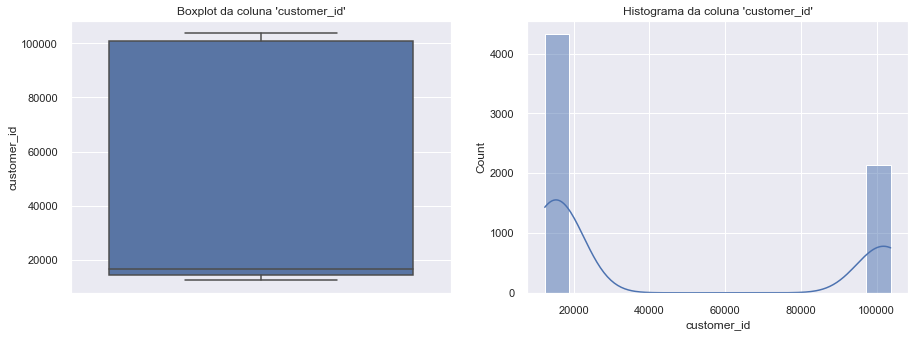

<Figure size 1080x360 with 0 Axes>

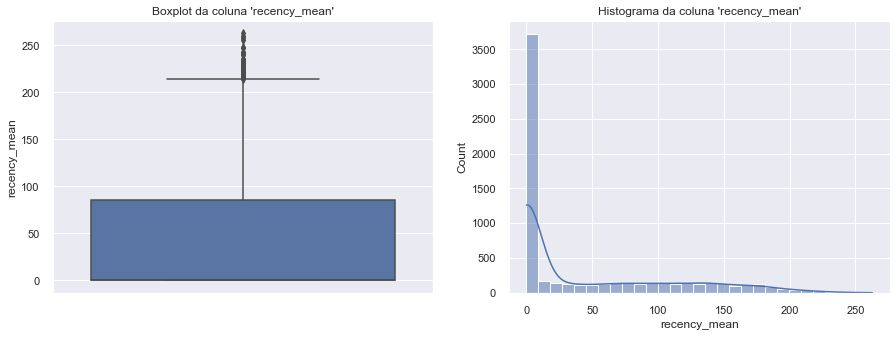

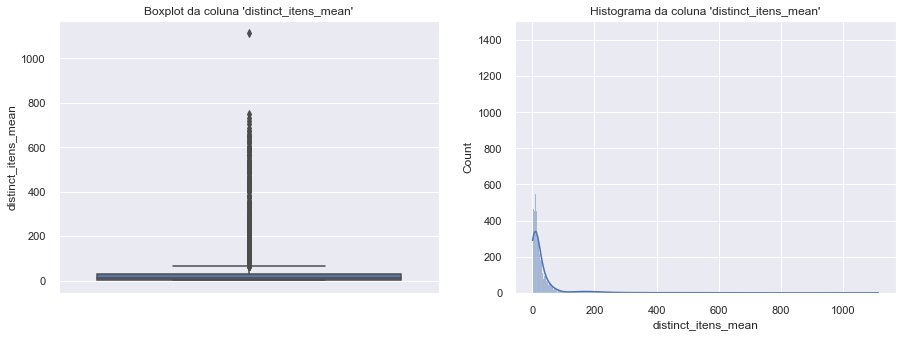

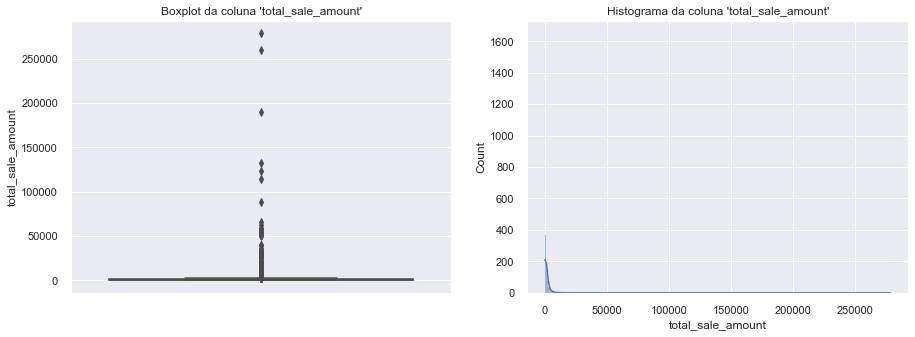

In [41]:
exploratori(df4)

## 4.2 Multivariate Analysis

In [42]:
display(HTML("<h1>Pair Plot</h1>"))
sns.pairplot(df4)

## 4.3 Estudo de Espaço (Embedding)

In [43]:
df43 = df4.copy()
df43.drop(columns=['customer_id'], inplace=True)

In [44]:
# Label Encoder
df43['country'] = LabelEncoder().fit_transform(df43['country'])

In [45]:
# Rescaling
mm = MinMaxScaler()

df43[['country', 
      'recency_mean', 
      'last_purchase_days',
      'frequency', 
      'qtt_mean', 
      'distinct_itens_mean', 
      'mean_price',
      'total_sale_amount']] = mm.fit_transform(df43[['country', 
                                                     'recency_mean', 
                                                     'last_purchase_days',
                                                     'frequency', 
                                                     'qtt_mean', 
                                                     'distinct_itens_mean', 
                                                     'mean_price',
                                                     'total_sale_amount']])

### 4.3.1 PCA - Principal Component Analysis

In [46]:
X = df43.copy()
pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

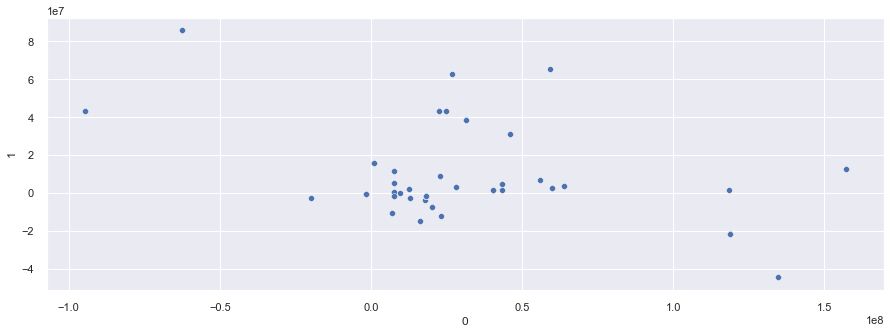

In [47]:
sns.scatterplot(data=df_pca, x=0, y=1)

### 4.3.2 UMAP - Uniform Manifold Approximation and Projection

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

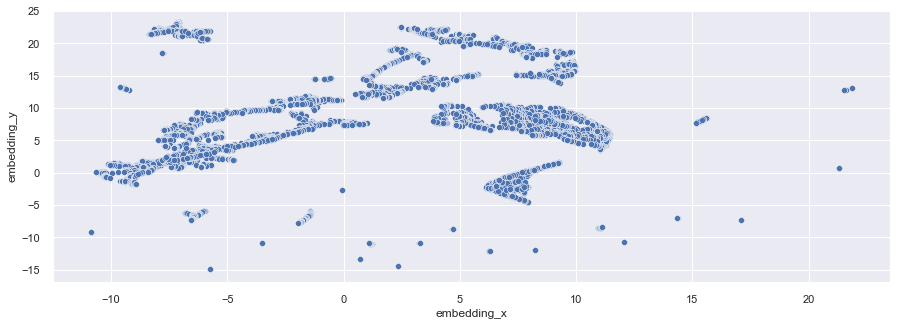

In [48]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(data=df_pca,
                x = 'embedding_x',
                y = 'embedding_y')

### 4.3.3 t-SNE -  t-Distributed Stochastic Neighbor Embedding

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

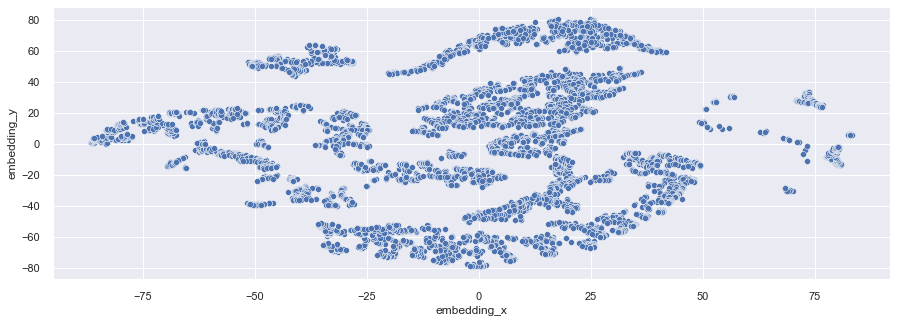

In [49]:
reducer = TSNE( random_state=42, n_components=2, n_jobs=-1 )
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot TSNE
sns.scatterplot(data=df_pca,
                x = 'embedding_x',
                y = 'embedding_y')

### 4.3.4 Tree-Based Embedding

In [50]:
# DataSet
X = df43.drop(columns=['total_sale_amount'])
y = df43['total_sale_amount']

# Model
rfr = RandomForestRegressor()

# Train
rfr_model = rfr.fit(X, y)

# DataFrame Leaf
df_leaf = pd.DataFrame(rfr_model.apply(X))

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

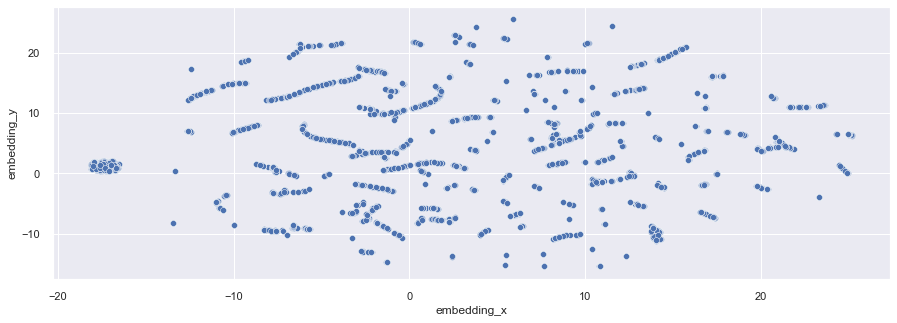

In [51]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(data=df_pca,
                x = 'embedding_x',
                y = 'embedding_y')

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

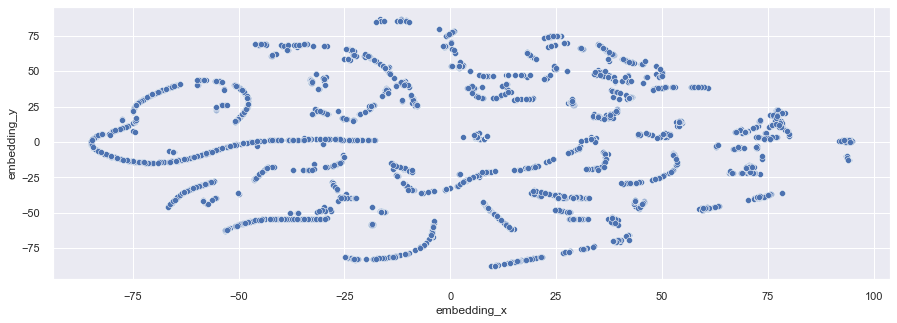

In [52]:
reducer = TSNE( random_state=42, n_components=2, n_jobs=-1 )
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot TSNE
sns.scatterplot(data=df_pca,
                x = 'embedding_x',
                y = 'embedding_y')

# 5. Data Preparation

In [221]:
df5 = df4.copy()

## 5.1 Rescaling

### 5.1.1 Study

1. Distribuição normal e não possui Outlier - Standart Scaler - Média e desvio padrão
2. Distribuição normal e possui Outlier - Robust Scaler - Quartis
3. Não distribuição normal - Min Max Scaler

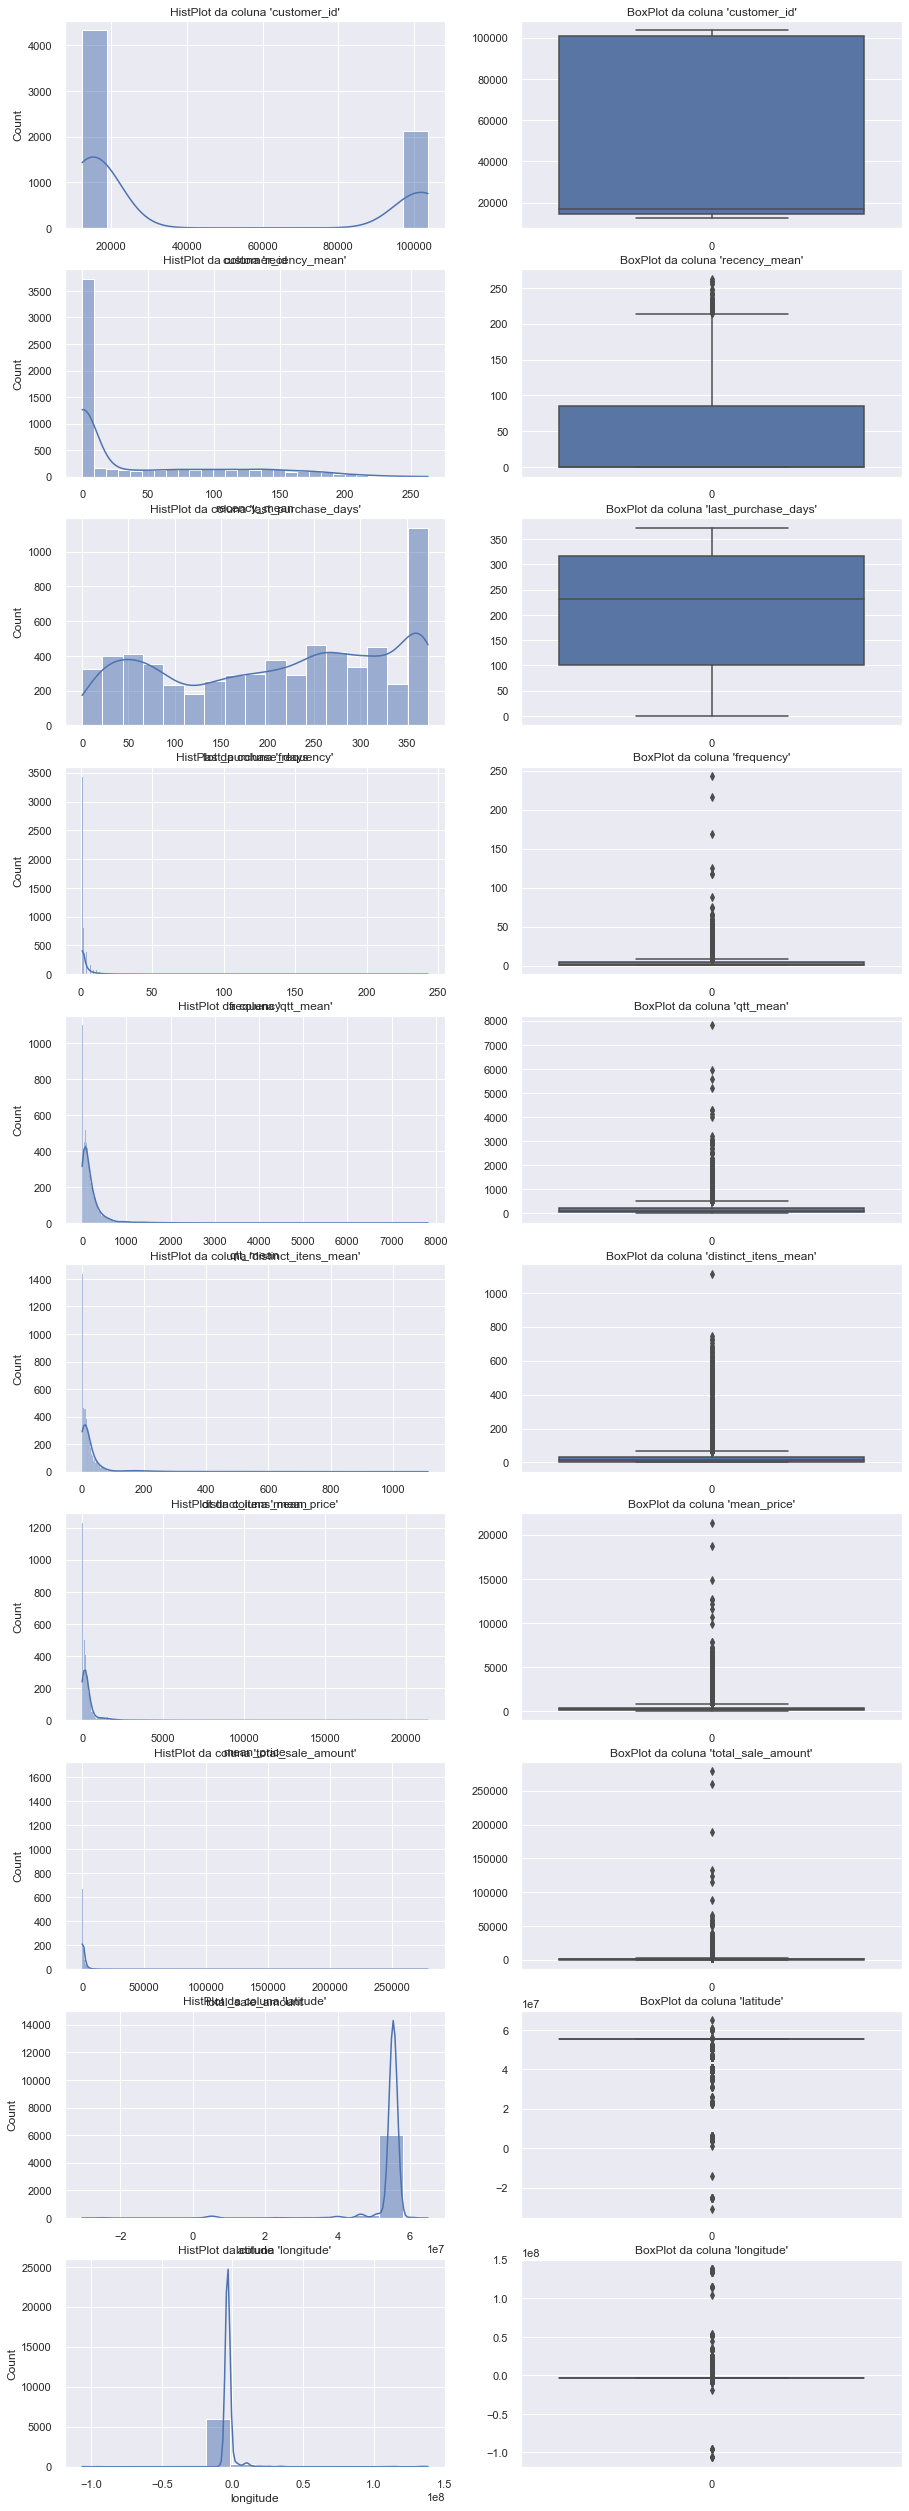

In [219]:
outliers_detect(df4)

### 5.1.2 Scalers

In [222]:
mm = MinMaxScaler()
re = RobustScaler()

df5['recency_mean']       = re.fit_transform(df5[['recency_mean'       ]])
df5['last_purchase_days'] = mm.fit_transform(df5[['last_purchase_days' ]])
df5['frequency']          = re.fit_transform(df5[['frequency'          ]])
df5['qtt_mean']           = re.fit_transform(df5[['qtt_mean'           ]])
df5['distinct_itens_mean']= re.fit_transform(df5[['distinct_itens_mean']])
df5['mean_price']         = re.fit_transform(df5[['mean_price'         ]])
df5['total_sale_amount']  = re.fit_transform(df5[['total_sale_amount'  ]])
df5['latitude']           = mm.fit_transform(df5[['latitude'           ]])
df5['longitude']          = mm.fit_transform(df5[['longitude'          ]])

In [223]:
df5

customer_id         country  recency_mean  last_purchase_days  \
0         17850.0  United Kingdom      0.797497            1.000000   
1         13047.0  United Kingdom      1.984672            1.000000   
2         12583.0          France      1.682439            1.000000   
3         13748.0  United Kingdom      1.322044            1.000000   
4         15100.0  United Kingdom      0.286131            1.000000   
...           ...             ...           ...                 ...   
6453     103706.0  United Kingdom      0.000000            0.002681   
6454     103707.0  United Kingdom      0.000000            0.000000   
6455     103708.0  United Kingdom      0.000000            0.000000   
6456     103709.0  United Kingdom      0.000000            0.000000   
6457      12713.0         Germany      0.000000            0.000000   

      frequency  qtt_mean  distinct_itens_mean  mean_price  total_sale_amount  \
0     11.333333 -0.361419            -0.189729   -0.204622           3.869671   
1      5.000000 -0.171688            -0.059327   -0.067200           2.105647   
2      5.333333  0.915705             0.009659    0.577558           4.944921   
3      1.333333 -0.155427            -0.324339   -0.078396           0.388685   
4      1.666667 -0.563629            -0.511167   -0.352813           0.137539   
...         ...       ...                  ...         ...                ...   
6453   0.000000  8.512952            25.198042   17.962924           4.198788   
6454   0.000000  9.886978            29.097069   21.424450           5.046550   
6455   0.000000  2.802647             1.844495    9.835841           2.208384   
6456   0.000000  3.204928             8.261644   12.237879           2.796667   
6457   0.000000  2.024207             0.950968    1.902454           0.265418   

      latitude  longitude  
0     0.899657   0.420732  
1     0.899657   0.420732  
2     0.803864   0.443829  
3     0.899657   0.420732  
4     0.899657   0.420732  
...        ...        ...  
6453  0.899657   0.420732  
6454  0.899657   0.420732  
6455  0.899657   0.420732  
6456  0.899657   0.420732  
6457  0.855559   0.477508  

[6458 rows x 11 columns]

# 6. Feature Selection

In [352]:
df6 = df5.copy()

In [353]:
train = df6.drop(columns=['customer_id', 'country'])

# 7. Machine Learning Modeling

In [58]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

## 7.1 K-Means

In [59]:
kmeans_list = []
for k in clusters:
    # Model
    km = KMeans(n_clusters=k, n_init='auto')

    # Train
    km_model = km.fit(train)

    # Predict
    labels = km_model.predict(train)

    # Performance
    silhouette = silhouette_score(train, labels)
    kmeans_list.append(silhouette)

Text(0.5, 1.0, 'Clusters x Silhouette Score')

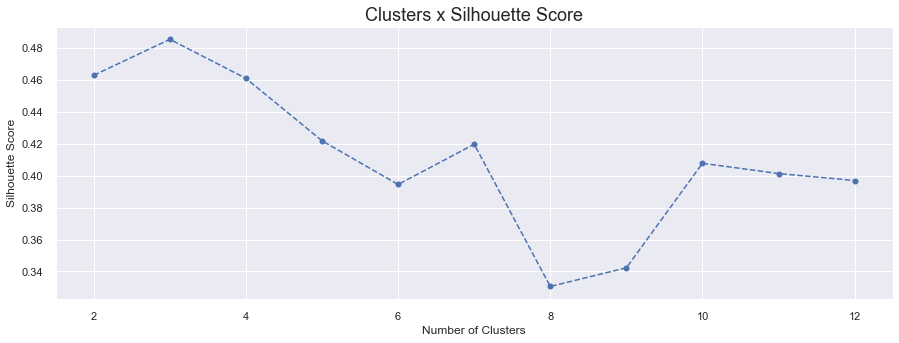

In [60]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clusters x Silhouette Score', fontdict={'fontsize':18})

## 7.2 GMM

In [61]:
gmm_list = []
for k in clusters:
    # Model
    gmm = GaussianMixture(n_components=k)

    # Training
    gmm_model = gmm.fit(train)

    # Predict
    labels = gmm_model.predict(train)

    # Performance
    silhouette = silhouette_score(train, labels)
    gmm_list.append(silhouette)

Text(0.5, 1.0, 'Clusters x Silhouette Score - GMM Model')

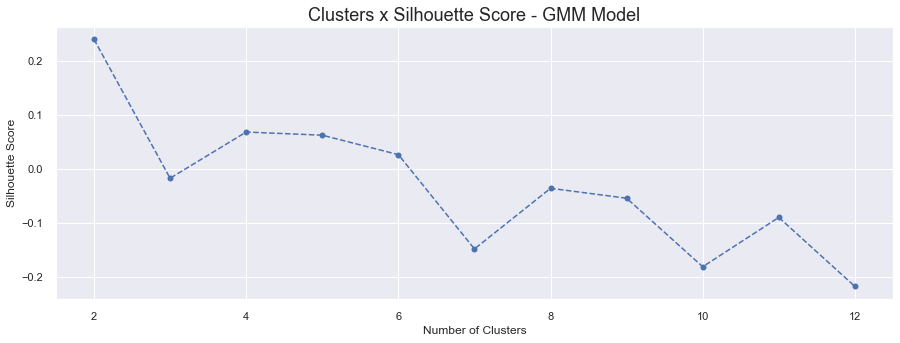

In [62]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clusters x Silhouette Score - GMM Model', fontdict={'fontsize':18})

## 7.3 Hierarchical Clustering

In [63]:
# Model and training
hc_model = linkage(train, 'ward')

[]

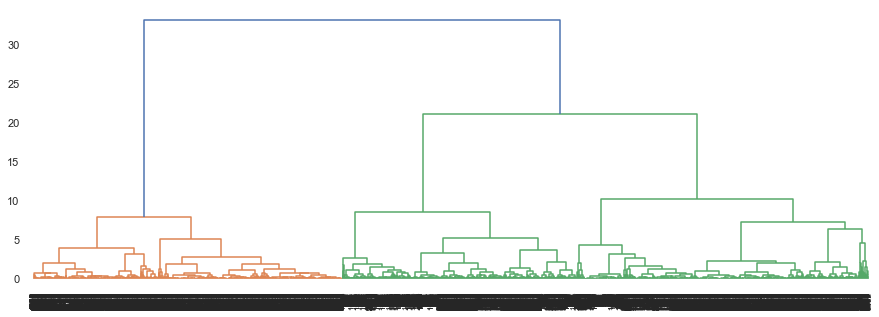

In [64]:
dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)

plt.plot()

In [65]:
dendrogram(hc_model,
           truncate_mode='lastp',
           p=10,
           leaf_rotation=90,
           leaf_font_size=8,
           show_contracted=True)

plt.show()

In [66]:
hc_list = []
for k in clusters:
    # model and Training
    hc_model = linkage(X, 'ward')

    # Predict
    labels = fcluster(hc_model, k, criterion='maxclust')

    # Performance
    silhouette = silhouette_score(train, labels)
    hc_list.append(silhouette)

Text(0.5, 1.0, 'Clusters x Silhouette Score - GMM Model')

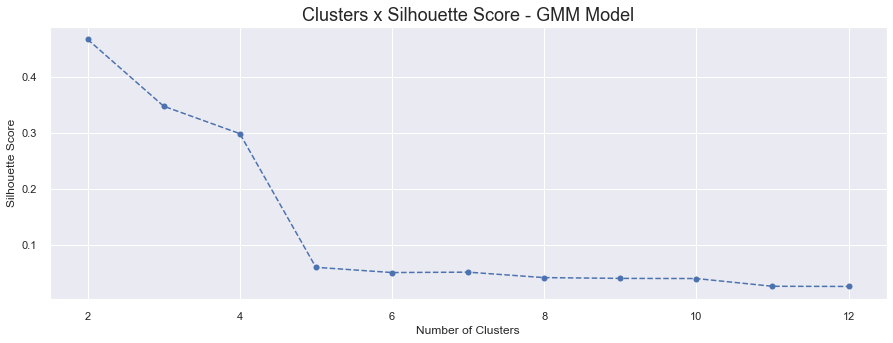

In [67]:
plt.plot(clusters, hc_list, linestyle='--', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clusters x Silhouette Score - GMM Model', fontdict={'fontsize':18})

for k=2, Silhouette Score= 0.4423583118828978
for k=3, Silhouette Score= 0.4471489079314698
for k=4, Silhouette Score= 0.39318428273445055
for k=5, Silhouette Score= 0.3565752026909852
for k=6, Silhouette Score= 0.30858248516068076
for k=7, Silhouette Score= 0.3241491273787143


IndexError: index 3 is out of bounds for axis 0 with size 3

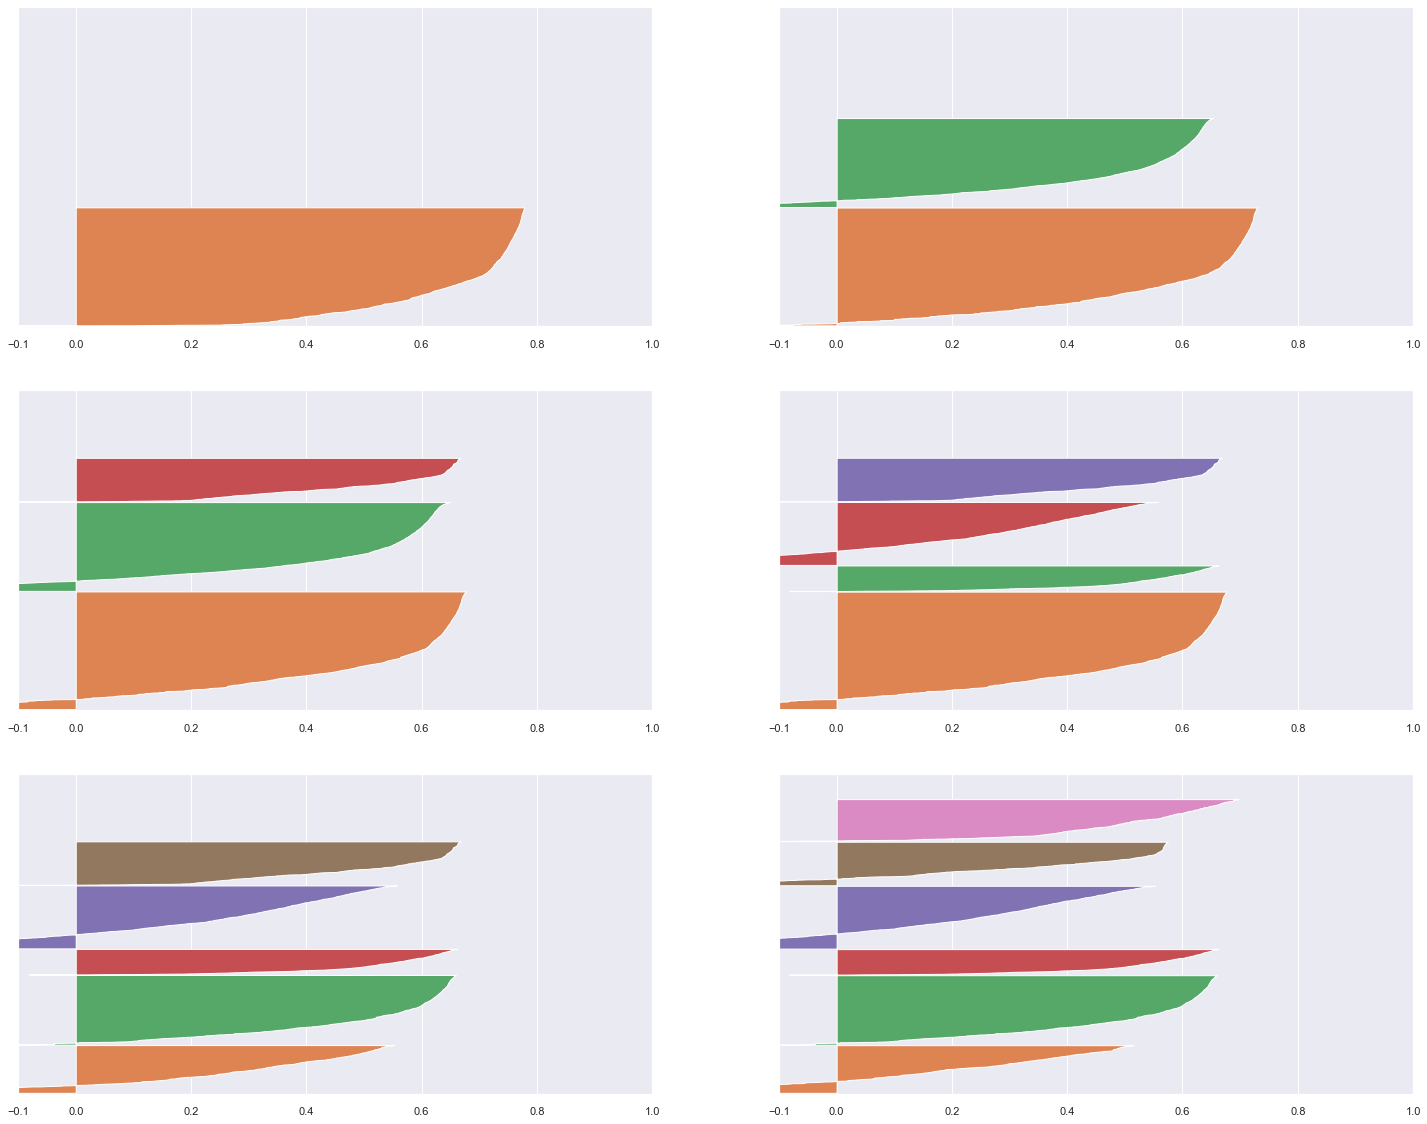

In [82]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(25, 20)

for k in clusters:
    q, mod = divmod(k, 2)
    ax[q - 1, mod].set_xlim([-0.1, 1])
    ax[q - 1, mod].set_ylim([0, len(train) + (k+1)*10 ])
    
    # model definition & training
    hc_model = linkage(train, 'ward')
    
    # model Predict
    labels = fcluster(hc_model, k, criterion='maxclust')
    
    # performance
    silhouette = silhouette_score(train, labels, metric='euclidean')
    print('for k={}, Silhouette Score= {}'.format(k, silhouette))
    
    samples_silhouette_values = silhouette_samples(train, labels)
    
    y_lower = 10
    for i in range(k):
        # select cluster
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # size cluster
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        
        # sort values
        ith_samples_silhouette_values.sort()
        y_upper = y_lower + size_cluster_i
        
        cmap = plt.get_cmap('Spectral')
        color = cmap(i/k)
        
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
    
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## 7.4 DBSCAN

In [396]:
# dbscan_results = pd.DataFrame()

# for min_samples in range(2, 24):
#     for eps in range(1, 26):
#         # Model
#         dbscan = DBSCAN(eps=(eps*0.01), min_samples=min_samples)

#         # Training & Predict
#         labels = dbscan.fit_predict(train)

#         # Performance
#         silhouette = silhouette_score(train, labels)
#         df_append = pd.DataFrame(data={'min_samples':[min_samples],
#                                        'eps':[(eps*0.01)],
#                                        'Silhouette Score':[silhouette],
#                                        'Number of Clusters':[len(np.unique(labels)[np.unique(labels) != -1])],
#                                        'Labels':[np.unique(labels)]})
#         dbscan_results = pd.concat([dbscan_results, df_append], ignore_index=True)

# dbscan_results.style.highlight_max(subset=['Silhouette Score'], color='lightgreen', axis=0)

In [402]:
# dbscan_results[dbscan_results['Number of Clusters'] > 1].sort_values(by=['Silhouette Score'], ascending=False).head(20)

min_samples   eps  Silhouette Score  Number of Clusters         Labels
99             5  0.25          0.340268                   3  [-1, 0, 1, 2]
98             5  0.24          0.339691                   3  [-1, 0, 1, 2]
146            7  0.22          0.329983                   2     [-1, 0, 1]
147            7  0.23          0.329094                   2     [-1, 0, 1]
199            9  0.25          0.328515                   2     [-1, 0, 1]
148            7  0.24          0.326018                   2     [-1, 0, 1]
124            6  0.25          0.325409                   3  [-1, 0, 1, 2]
174            8  0.25          0.324408                   2     [-1, 0, 1]
149            7  0.25          0.324408                   2     [-1, 0, 1]
123            6  0.24          0.323954                   3  [-1, 0, 1, 2]
122            6  0.23          0.322578                   3  [-1, 0, 1, 2]
121            6  0.22          0.319923                   3  [-1, 0, 1, 2]
322           14  0.23          0.305888                   2     [-1, 0, 1]
372           16  0.23          0.305888                   2     [-1, 0, 1]
298           13  0.24          0.305888                   2     [-1, 0, 1]
373           16  0.24          0.305888                   2     [-1, 0, 1]
347           15  0.23          0.305888                   2     [-1, 0, 1]
323           14  0.24          0.305888                   2     [-1, 0, 1]
348           15  0.24          0.305888                   2     [-1, 0, 1]
297           13  0.23          0.305888                   2     [-1, 0, 1]

In [74]:
dbscan_results = pd.DataFrame()
eps = 25
min_samples=5

# Model
dbscan = DBSCAN(eps=(eps*0.01), min_samples=min_samples)

# Training & Predict
labels = dbscan.fit_predict(train)

# Performance
silhouette = silhouette_score(train, labels)
df_append = pd.DataFrame(data={'min_samples':[min_samples],
                               'eps':[(eps*0.01)],
                               'Silhouette Score':[silhouette],
                               'Number of Clusters':[len(np.unique(labels)[np.unique(labels) != -1])],
                               'Labels':[np.unique(labels)]})
dbscan_results = pd.concat([dbscan_results, df_append], ignore_index=True)

dbscan_results.style.highlight_max(subset=['Silhouette Score'], color='lightgreen', axis=0)

In [83]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(train)
distances, indices = neighbors.kneighbors(train)

In [84]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
elbow = np.array([[index, value] for index, value in enumerate(distances, start=1)])

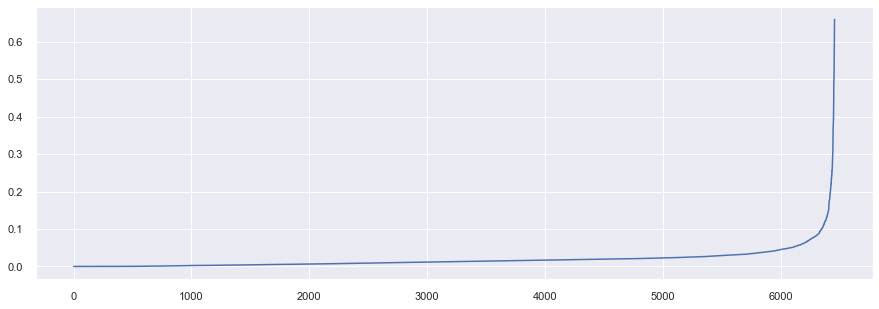

In [85]:
plt.plot(distances)

## 7.5 Results

In [86]:
df_results = pd.DataFrame({'K-Means':kmeans_list,
                           'GMM':gmm_list,
                           'HC': hc_list}, index=clusters).T
df_results

2         3         4         5         6         7         8   \
K-Means  0.462996  0.485499  0.461046  0.421916  0.394528  0.419753  0.330610   
GMM      0.239887 -0.017551  0.068110  0.062225  0.026226 -0.148593 -0.036240   
HC       0.467690  0.348301  0.299313  0.060661  0.051327  0.051988  0.042267   

               9         10        11        12  
K-Means  0.342301  0.407813  0.401372  0.397007  
GMM     -0.054565 -0.181601 -0.090162 -0.218113  
HC       0.040874  0.040610  0.026784  0.026491

## 7.6 Machine Learning Modelation with Embedding

In [230]:
sns.set(rc={'figure.figsize':(15,5)})

In [257]:
# DataSet
X = df4.drop(columns=['total_sale_amount', 'customer_id', 'country'])
y = df4['total_sale_amount']

# Model
rfr = RandomForestRegressor()

# Train
rfr_model = rfr.fit(X, y)

# DataFrame Leaf
df_leaf = pd.DataFrame(rfr_model.apply(X))

In [258]:
# Feature Selection - Elapsed Date
rfc_importances = rfr_model.feature_importances_

pd.DataFrame(list(zip(X.columns.tolist(), rfc_importances))).sort_values(by=1, ascending=False).T

2           5             0         3                   1  \
0  frequency  mean_price  recency_mean  qtt_mean  last_purchase_days   
1   0.463698    0.251086      0.125256  0.072111            0.045438   

          6          7                    4  
0  latitude  longitude  distinct_itens_mean  
1  0.023678   0.011187             0.007546

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

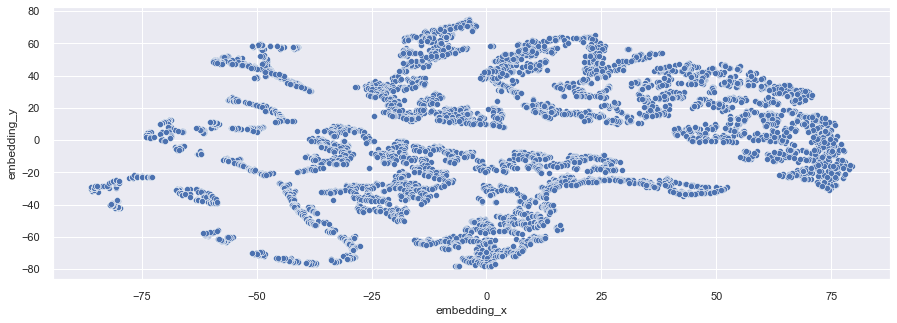

In [378]:
# t-SNE
reducer = TSNE( random_state= 42, n_components=2, n_jobs=-1 )
embedding = reducer.fit_transform(train[[
                                         'recency_mean', 
                                         'last_purchase_days', 
                                         'frequency', 
                                         #'qtt_mean',
                                         #'distinct_itens_mean', 
                                         #'mean_price', 
                                         'total_sale_amount', 
                                         'latitude',
                                         'longitude'
                                        ]])

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot TSNE
sns.scatterplot(data=df_pca,
                x = 'embedding_x',
                y = 'embedding_y')

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

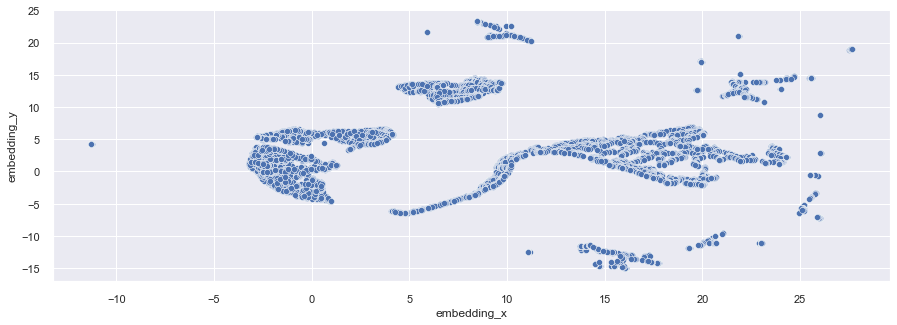

In [382]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform(train[[
                                         'recency_mean', 
                                         'last_purchase_days', 
                                         'frequency', 
                                         #'qtt_mean',
                                         #'distinct_itens_mean', 
                                         'mean_price', 
                                         'total_sale_amount', 
                                         'latitude',
                                         'longitude'
                                        ]])

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(data=df_pca,
                x = 'embedding_x',
                y = 'embedding_y')

In [386]:
clusters = list(range(2, 31, 1))

Text(0.5, 1.0, 'Clusters x Silhouette Score - GMM Model')

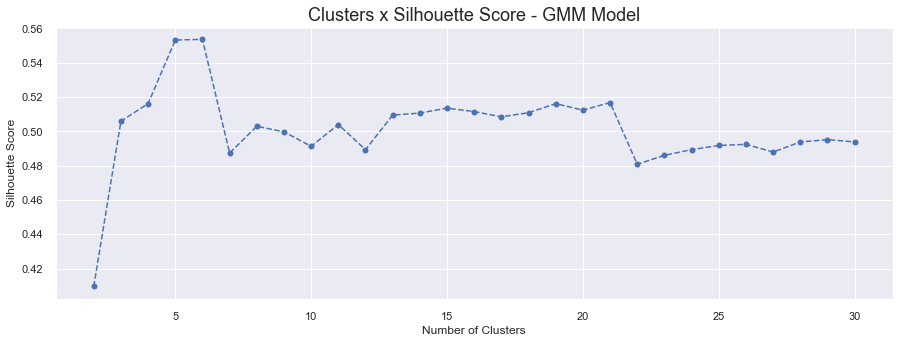

In [387]:
hc_list = []
for k in clusters:
    # model and Training
    hc_model = linkage(df_pca[['embedding_x', 'embedding_y']], 'ward')

    # Predict
    labels = fcluster(hc_model, k, criterion='maxclust')

    # Performance
    silhouette = silhouette_score(df_pca[['embedding_x', 'embedding_y']], labels)
    hc_list.append(silhouette)
    
plt.plot(clusters, hc_list, linestyle='--', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clusters x Silhouette Score - GMM Model', fontdict={'fontsize':18})

In [391]:
k=5
# model and Training
hc_model = linkage(df_pca[['embedding_x', 'embedding_y']], 'ward')

# Predict
labels = fcluster(hc_model, k, criterion='maxclust')

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

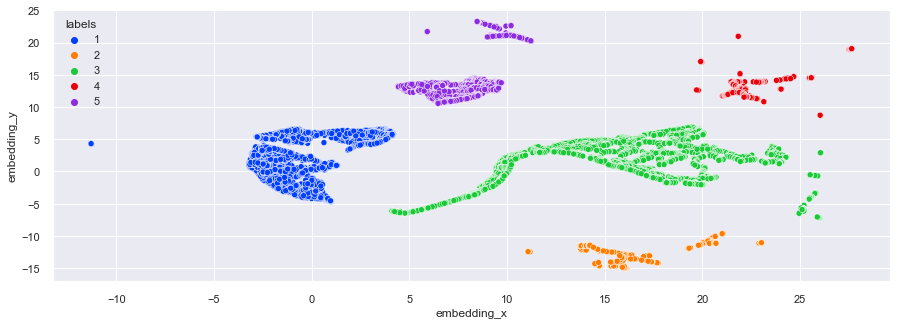

In [392]:
df7 = df_pca.copy()
df7['labels'] = labels

# Plot UMAP
sns.scatterplot(data=df7,
                x = 'embedding_x',
                y = 'embedding_y',
                hue = 'labels',
                palette= 'bright')

In [395]:
df7 = df4.copy()
df7['labels'] = labels

df7[['recency_mean', 
     'last_purchase_days', 
     'frequency', 'qtt_mean', 
     'distinct_itens_mean', 
     'mean_price', 
     'total_sale_amount',
     'labels']].groupby('labels').mean().sort_values(by=['total_sale_amount'])

recency_mean  last_purchase_days  frequency    qtt_mean  \
labels                                                            
2           0.016624           40.391304   1.002558   34.769821   
4           0.000000          263.936275   1.000000   52.056373   
5          38.307732          230.239175   1.805155  132.692784   
3           0.126841          164.625205   1.006956  285.288291   
1         109.519153          274.995991   8.402227  199.253428   

        distinct_itens_mean  mean_price  total_sale_amount  
labels                                                      
2                  1.815857    4.785448           4.785448  
4                  2.465686    9.674436           9.674436  
5                 15.954124  205.220108         407.400866  
3                 65.164587  769.314459         798.808756  
1                 19.232869  324.732214        3272.584227

# 8. Model Training

In [256]:
# Nº de clusters
k = 4

# Modelo
kmeans = KMeans(n_clusters=4,
                init='random',
                n_init=10,
                max_iter=100,
                random_state=42)

# Treinamento do Modelo
kmeans.fit(train)

# Clusters
labels = kmeans.labels_

In [257]:
# WCSS
print('WCSS value: {}'.format(kmeans.inertia_))

# SS
print('SS value: {}'.format(mt.silhouette_score(train, labels, metric='euclidean')))

WCSS value: 54347898943.9502
SS value: 0.7972812150422395


## UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

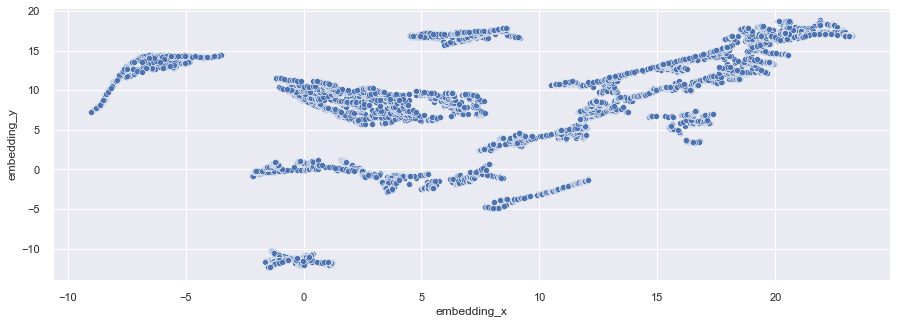

In [51]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(data=df_pca,
                x = 'embedding_x',
                y = 'embedding_y')

In [59]:
df432 = df4.copy()
df432 = pd.concat([df432, df_pca[['embedding_x', 'embedding_y']]], axis=1)

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

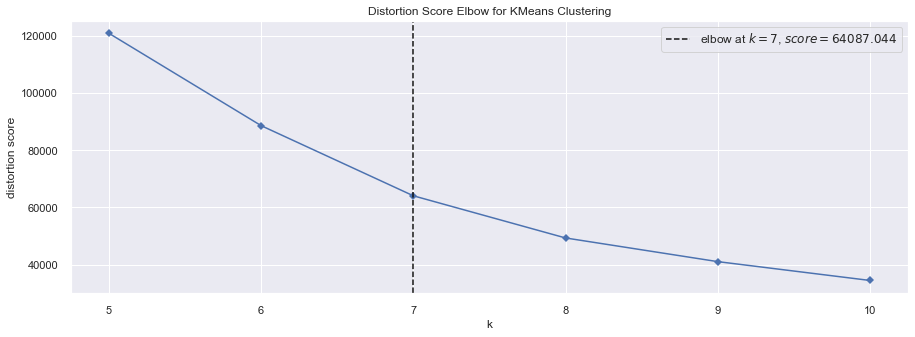

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
# ML Modeling
clusters = [5, 6, 7, 8, 9, 10]
Elbow_M = KElbowVisualizer(KMeans(), k=clusters, timings=False)
Elbow_M.fit(train)
Elbow_M.show()

In [70]:
# Train Data
train = df432[['embedding_x', 'embedding_y']]

# Nº de clusters
k = 7

# Modelo
kmeans = KMeans(n_clusters=k,
                init='random',
                n_init=10,
                max_iter=100,
                random_state=42)

# Treinamento do Modelo
kmeans.fit(train)

# Clusters
labels = kmeans.labels_

In [71]:
df432['label'] = labels

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

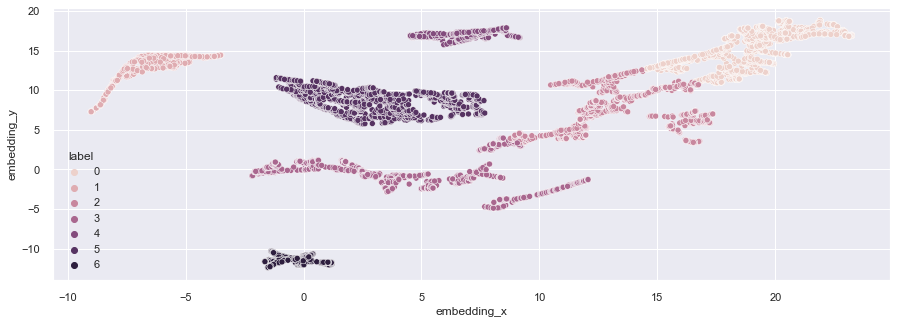

In [72]:
# Plot UMAP
sns.scatterplot(data=df432,
                x = 'embedding_x',
                y = 'embedding_y',
                hue='label')

# 9. Cluster Analisys

In [198]:
df9 = df6.copy()
df9['label'] = labels
df9.head()

customer_id  invoice_no  itens_qtt  total_qtt  total_invoice_price  \
0        14644      569239         18        192               643.26   
1        18059      569240          5         80               114.96   
2        14488      569241         44        775              1034.28   
3        14193      569242         17        171               400.85   
4        13344      569243         33        250               531.49   

  invoice_date  country  invoice_day  invoice_month  invoice_year  label  
0   2017-10-01       26            1             10          2017      2  
1   2017-10-01       26            1             10          2017      2  
2   2017-10-01       26            1             10          2017      0  
3   2017-10-01       26            1             10          2017      2  
4   2017-10-01       26            1             10          2017      2

## 9.1 Visualization Inspection

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


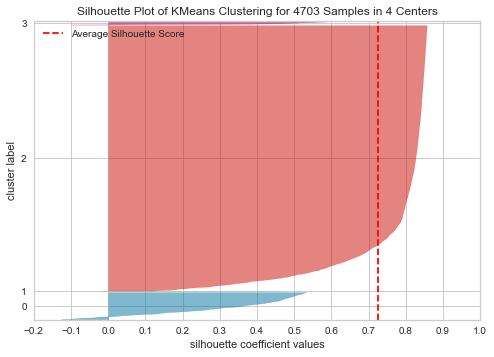

In [199]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(train)
visualizer.finalize()

## 9.2 2D Plod

In [200]:
df9.head()

customer_id  invoice_no  itens_qtt  total_qtt  total_invoice_price  \
0        14644      569239         18        192               643.26   
1        18059      569240          5         80               114.96   
2        14488      569241         44        775              1034.28   
3        14193      569242         17        171               400.85   
4        13344      569243         33        250               531.49   

  invoice_date  country  invoice_day  invoice_month  invoice_year  label  
0   2017-10-01       26            1             10          2017      2  
1   2017-10-01       26            1             10          2017      2  
2   2017-10-01       26            1             10          2017      0  
3   2017-10-01       26            1             10          2017      2  
4   2017-10-01       26            1             10          2017      2

In [205]:
df_viz = df9.drop(columns=['customer_id', 'invoice_no'])
sns.pairplot(data=df_viz, hue='label')

## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

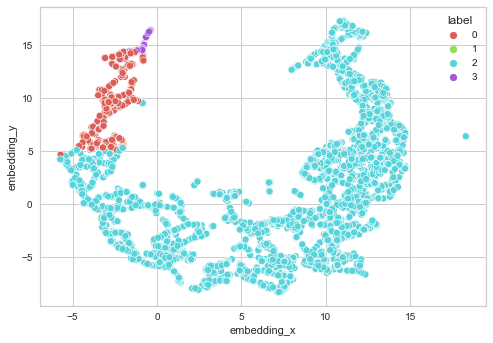

In [215]:
reducer = umap.UMAP( random_state=42, n_neighbors=5 )
embedding = reducer.fit_transform(train)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(data=df_viz,
                x = 'embedding_x',
                y = 'embedding_y',
                hue = 'label',
                palette = sns.color_palette('hls', n_colors=len(df_viz['label'].unique())))